# Step 1: Importing Libraries

In [2]:
# data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# text preprocessing
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

# modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report,confusion_matrix, ConfusionMatrixDisplay



In [4]:
! kaggle datasets download -d chandramoulinaidu/spam-classification-for-basic-nlp

Dataset URL: https://www.kaggle.com/datasets/chandramoulinaidu/spam-classification-for-basic-nlp
License(s): CC0-1.0




  0%|          | 0.00/5.69M [00:00<?, ?B/s]
 18%|█▊        | 1.00M/5.69M [00:00<00:00, 7.28MB/s]
 53%|█████▎    | 3.00M/5.69M [00:00<00:00, 10.1MB/s]
 88%|████████▊ | 5.00M/5.69M [00:00<00:00, 11.0MB/s]
100%|██████████| 5.69M/5.69M [00:00<00:00, 10.7MB/s]


In [17]:
! unzip spam-classification-for-basic-nlp.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Step 2: Load and Prepare Dataset

In [2]:
# Load Dataset
df = pd.read_csv("data/Restaurant_Reviews.tsv"
                 , sep='\t')
df.head()

<IPython.core.display.Javascript object>

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [6]:
# # Load text and label columns only
# df = df[['','']]

# rename columns
df.columns = ['text','label']
df.head()

,text,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [8]:
# df.head()

In [9]:
# # Concatenate and Reset Index
# df = pd.concat([df, df_val])
# df.reset_index(inplace=True, drop=True)

In [10]:
# df=df.drop(columns=['id','entity'],axis=1)
# df

In [11]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [12]:
# ## 1 -step make the list of features which has missing values
# na_features=[features for features in df.columns if df[features].isnull().sum()>1]
# ## 2- step print the feature name and the percentage of missing values

# for feature in na_features:
#     print(f"{feature:<15}{np.round(df[feature].isnull().mean(), 4):^10}{'% missing values':>20}")

In [13]:
# # Drop the columns containing missing values, determine number of remaining values
# df = df.dropna()
# df

In [14]:
df.duplicated().sum() 

4

In [15]:
# # Check for duplicates
# print('Shape of dataframe:', df.shape)
# print('Shape of dataframe with duplicates dropped:', df.drop_duplicates().shape)

# df_row = len(df)
# df_row_no_dupe = len(df.drop_duplicates())
# df_row_dupe = df_row - df_row_no_dupe

# print('No. of rows with duplicates :', df_row_dupe)

In [16]:
df = df.drop_duplicates(keep='first')
df.shape

(996, 2)

In [17]:
# df.head()

# Step 3: Visualizing Text Data

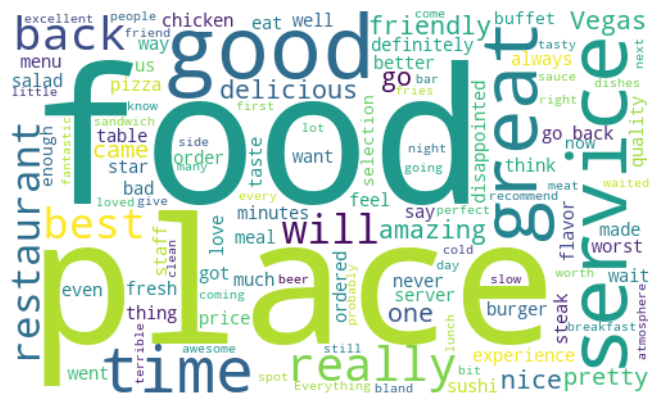

In [18]:
# Generate Word Cloud
wordcloud = WordCloud(width=500, height=300, background_color='white', min_font_size=10).generate(' '.join(df['text']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
count=df['label'].value_counts(normalize='true')*100
count

label
1    50.100402
0    49.899598
Name: proportion, dtype: float64

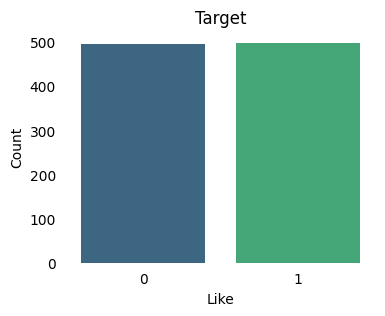

In [20]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(4,3))
ax.tick_params(left=False, bottom=False) # Remove ticks
sns.despine(left=True, bottom=True) # Remove borders borders

# define order the graph but also only showing top 25 rows
sns.countplot(df, x='label',palette='viridis', hue='label',legend=False)
plt.title("Target", fontsize=12)
plt.ylabel("Count")
plt.xlabel("Like")
plt.xticks(
            # rotation=45, 
            ha='center')
plt.show()

# Step 4: Data Preprocessing

In [21]:
# function to convert POS tags into a format that's compatible with WordNet lemmatization in NLTK.
def get_tag(tag):
  if tag.startswith('J'):
    return 'a'
  elif tag.startswith('V'):
    return 'v'
  elif tag.startswith('N'):
    return 'n'
  elif tag.startswith('R'):
    return 'r'
  else:
    return 'n'

In [22]:
# Text Preprocessing Function
def preprocess_text(text):

    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation

    # Lemmatize words and remove stopwords
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in set(stopwords.words('english')))  
    return text

# Apply Preprocessing
df['text'] = df['text'].apply(preprocess_text)

In [23]:
df.head()

,text,label
0,wow loved place,1
1,crust good,0
2,tasty texture nasty,0
3,stopped late may bank holiday rick steve recom...,1
4,selection menu great price,1


In [24]:
def preprocess_word(word_list):

  # Remove stopwords
  word_list = [word for word in word_list if word.lower() not in stopwords.words('english')]

  # Remove punctuation
  word_list = [word for word in word_list if word.lower() not in string.punctuation]

  # Remove number
  word_list = [word for word in word_list if word.isalpha()]

  # Pos tag
  word_tag = pos_tag(word_list)

  # Lemmatizing
  wnl = WordNetLemmatizer()
  word_list = [wnl.lemmatize(word, pos=get_tag(tag)) for word, tag in word_tag]

  # Stemming
  stemmer = PorterStemmer()
  word_list = [stemmer.stem(word) for word in word_list]

  return word_list

In [25]:
# Apply Preprocessing
df2 = df['text'].apply(preprocess_word)

In [26]:
df2.head()

0                          [w, w, l, v, e, p, l, c, e]
1                                         [c, r, u, g]
2                                   [e, x, u, r, e, n]
3    [p, p, e, l, e, b, n, k, h, l, r, c, k, e, v, ...
4        [e, l, e, c, n, e, n, u, g, r, e, p, r, c, e]
Name: text, dtype: object

In [27]:
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()

# corpus = []
# for i in range(0, len(df)):                                         # Iterate through each message in the list
#     review = re.sub('[^a-zA-Z]', ' ', df['Text'][i])                # Replace all non-alphabetic characters with spaces
#     review = review.lower()                                         # Convert all text to lowercase
#     review = review.split()                                         # Split the text into individual words
    
#     # Stem each word (reduce to root form) and filter out stop words
#     review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
#     review = ' '.join(review)                                       # Join the words back into a string
#     corpus.append(review)                                           # Add the processed review to the corpus



In [28]:
# corpus

In [29]:
# # Create one-hot encoded labels from the 'label' column
# df= pd.get_dummies(df, drop_first=True, columns=['label'])
# df.head()

# Step 5: Feature Extraction

In [30]:
# Convert Text Data into Vectors

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df['text'])

y = df['label']


In [31]:
# Split Data into Training and Testing Sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Model Training and Evaluation

In [32]:
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV


def evaluate_models(models, X_train, y_train, X_test, y_test, param_grid_dict=None):
    """
    Evaluates a dictionary of models with hyperparameter tuning (optional) and outputs a table of results.
    Also pickles each trained model.

    Args:
        models (dict): A dictionary where keys are model names and values are scikit-learn models.
        X_train (array): Training data.
        y_train (array): Training labels.
        X_test (array): Testing data.
        y_test (array): Testing labels.
        param_grid_dict (dict, optional): A dictionary where keys are model names and
                                          values are dictionaries defining the hyperparameter grid for GridSearchCV.
                                          Defaults to None.

    Returns:
        pandas.DataFrame: A DataFrame containing the evaluation results, including best hyperparameters if tuning was performed.
    """

    results = []
    path = 'models/'  # Path to save pickled models

    for name, model in models.items():
        if param_grid_dict is not None and name in param_grid_dict:
            # Perform hyperparameter tuning with GridSearchCV
            grid_search = GridSearchCV(model, param_grid_dict[name], scoring='accuracy', cv=5)
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            model.fit(X_train, y_train)
            best_params = None

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        # Pickle the trained model
        with open(path + name + '.pkl', 'wb') as f:
            pickle.dump(model, f)

        print(f"\n--- Evaluation Results for {name} ---\n")
        print(f"Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        # print("\nClassification Report:\n\n", classification_report(y_test, y_pred))

        results.append({
            'Model Name': name,
            'Best Hyperparameters': best_params,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall
        })

    df = pd.DataFrame(results)

    # Save the master results table (unchanged)
    df.to_csv(path+'results_table.csv', index=False)

    return df


# Fit models
models = {
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
}

# Define hyperparameter grids 
param_grid_dict = {
    'Decision Tree': {
        'max_depth': [2, 4, 6],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [2, 4, 6]
    }
}

evaluate_models(models, X_train, y_train, X_test, y_test, param_grid_dict)


--- Evaluation Results for Naive Bayes ---

Confusion Matrix:
 [[88 18]
 [26 68]]

--- Evaluation Results for Decision Tree ---

Confusion Matrix:
 [[100   6]
 [ 60  34]]

--- Evaluation Results for Random Forest ---

Confusion Matrix:
 [[73 33]
 [17 77]]


,Model Name,Best Hyperparameters,Accuracy,Precision,Recall
0,Naive Bayes,None,0.78,0.780751,0.78
1,Decision Tree,"{'max_depth': 6, 'min_samples_split': 2}",0.67,0.730750,0.67
2,Random Forest,"{'max_depth': 6, 'n_estimators': 200}",0.75,0.758889,0.75


# Step 7: Load New Test Data and Make Predictions

In [33]:
# Load New Test Data
df_val=pd.read_csv('data/Restaurant_Reviews.tsv'
                   , sep='\t')
df_val.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [34]:
# rename columns
df_val.columns = ['text','label']
df_val.head()

,text,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [35]:
print('Validation shape:', df_val.shape)
print('\nNo. missing values:\n', df_val.isnull().sum())
print('\nNo. Duplicates:',df_val.duplicated().sum())

Validation shape: (1000, 2)

No. missing values:
 text     0
label    0
dtype: int64

No. Duplicates: 4


In [36]:
# drop Duplicates and Missing Values
df_val = df_val.dropna()
df_val = df_val.drop_duplicates(keep='first')
print('Cleaned shape:', df_val.shape)

Cleaned shape: (996, 2)


In [37]:
# Preprocess Text
df_val['text'] = df_val['text'].apply(preprocess_text)


In [38]:
# Convert Text Data into Vectors

X_test_new = vectorizer.transform(df_val['text'])

y_test_new = df_val['label']


In [39]:
# Fit models
models = {
    'Naive Bayes': MultinomialNB(),
    # 'Decision Tree': DecisionTreeClassifier(),
    # 'Random Forest': RandomForestClassifier(),
}

# Define hyperparameter grids 
param_grid_dict = {
    'Decision Tree': {
        'max_depth': [2, 4, 6],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [2, 4, 6]
    }
}

evaluate_models(models, X_train, y_train, X_test, y_test, param_grid_dict)



--- Evaluation Results for Naive Bayes ---

Confusion Matrix:
 [[88 18]
 [26 68]]


,Model Name,Best Hyperparameters,Accuracy,Precision,Recall
0,Naive Bayes,None,0.78,0.780751,0.78
